In [103]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from itertools import product
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np
import time

# Load wine quality dataset
wine_data = pd.read_csv("WineQT.csv")
wine_data = wine_data.drop(columns=['Id'])
X_wine = wine_data.drop(columns=['quality'])
y_wine = wine_data['quality']

# Load housing dataset
housing_data = pd.read_csv("HousingData.csv")
X_housing = housing_data.drop(columns=['MEDV'])
y_housing = housing_data['MEDV']

# Hyperparameter ranges
n_estimators_range = [50, 100, 150]
sample_fractions = [0.15, 0.25, 0.5, 0.75, 1.0]
bootstrap_options = [True, False]
voting_options = ['soft', 'hard']

In [104]:
def get_data(X,y):
    y=np.array(y)
    y = y[:, np.newaxis]
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)
    
    # Handle missing data (if any)
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_val = imputer.transform(X_val)
    X_test = imputer.transform(X_test)
    
    # Normalize the data using Min-Max scaling
    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_val_normalized = scaler.transform(X_val)
    X_test_normalized = scaler.transform(X_test)
    return X_train_normalized,X_val_normalized,X_test_normalized,y_train,y_val,y_test

base_model_accuracies_classification = []
ensemble_model_accuracies_classfication = []
base_model_accuracies_regression = []
ensemble_model_accuracies_regression = []

classification_accuracies = []
classification_training_times = []
bagging_classification_training_times = []

In [105]:
class BaggingEnsemble:
    def __init__(self, base_estimator, n_estimators, sample_fraction, bootstrap, voting, task, params):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.sample_fraction = sample_fraction
        self.bootstrap = bootstrap
        self.voting = voting
        self.task = task
        self.params = params
        self.models = []

    def fit(self, X, y, X_val=None, y_val=None):
        for _ in range(self.n_estimators):
            sample_indices = self._get_sample_indices(len(X))
            X_sampled, y_sampled = X[sample_indices], y[sample_indices]
            model = self.base_estimator(**self.params)
            model.fit(X_sampled, y_sampled)

            if self.task == 'regression' and X_val is not None and y_val is not None:
                val_predictions = model.predict(X_val)
                confidence = 1.0 - mean_squared_error(y_val, val_predictions) / np.var(y_val)
            else:
                confidence = 1.0  # Default confidence for classification and regression without a validation set

            setattr(model, 'confidence', confidence)
            self.models.append(model)

    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])

        if self.task == 'classification':
            if self.voting == 'hard':
                return np.round(np.mean(predictions, axis=0))
            elif self.voting == 'soft':
                return np.round(np.mean(predictions, axis=0))  # Simple majority vote for classification
            else:
                raise ValueError("Invalid voting mechanism. Use 'hard' or 'soft'.")
        elif self.task == 'regression':
            if self.voting == 'hard':
                return np.round(np.mean(predictions, axis=0))
            elif self.voting == 'soft':
                confidences = np.array([getattr(model, 'confidence', 1.0) for model in self.models])
                weighted_predictions = np.average(predictions, axis=0, weights=confidences)
                return weighted_predictions
            else:
                raise ValueError("Invalid voting mechanism. Use 'hard' or 'soft'.")
        else:
            raise ValueError("Invalid task. Use 'classification' or 'regression'.")

    def _get_sample_indices(self, n_samples):
        if self.bootstrap:
            return np.random.choice(n_samples, size=int(self.sample_fraction * n_samples), replace=True)
        else:
            return np.random.choice(n_samples, size=int(self.sample_fraction * n_samples), replace=False)

In [18]:
def grid_search(X, y, base_estimator, n_estimators_range, sample_fractions, bootstrap_options, voting_options, task,params):
    best_model = None
    best_score = float('inf') if task == 'regression' else float('-inf')
    best_hyperparameters = None
    
    X_train_normalized,X_val_normalized,X_test_normalized,y_train,y_val,y_test = get_data(X,y)
    
    for n_estimators, sample_fraction, bootstrap, voting in product(n_estimators_range, sample_fractions, bootstrap_options, voting_options):
        model = BaggingEnsemble(base_estimator, n_estimators, sample_fraction, bootstrap, voting, task,params)
        
        if task == 'regression':
            model.fit(X_train_normalized, y_train, X_val_normalized, y_val)
            predictions = model.predict(X_test_normalized)
            score = mean_squared_error(y_test, predictions)
        else:
            model.fit(X_train_normalized, y_train)
            predictions = model.predict(X_test_normalized)
            score = accuracy_score(y_test, predictions)
            
        print(f"Hyperparameters: n_estimators={n_estimators}, sample_fraction={sample_fraction}, bootstrap={bootstrap}, voting={voting} Params={params}")
        print(f"MSE Loss: {score}" if task == 'regression' else f"Accuracy: {score}")
        print("=" * 50)
        
        if ((task == 'classification' and score > best_score)):
                best_model = model
                best_score = score
                best_hyperparameters = {
                    'n_estimators': n_estimators,
                    'sample_fraction': sample_fraction,
                    'bootstrap': bootstrap,
                    'voting': voting,
                    'Classification_params': params,
                    'Accuracy': score
                }

        if ((task == 'regression' and score < best_score)):
            best_model = model
            best_score = score
            best_hyperparameters = {
                'n_estimators': n_estimators,
                'sample_fraction': sample_fraction,
                'bootstrap': bootstrap,
                'voting': voting,
                'Regression_params': params,
                'MSE Loss': score
            }
    return best_model, best_hyperparameters

In [107]:
max_depth_options=[5]

model=DecisionTreeRegressor(max_depth=5)
X_train_normalized,X_val_normalized,X_test_normalized,y_train,y_val,y_test=get_data(X_housing,y_housing)
model.fit(X_train_normalized,y_train)
predictions=model.predict(X_test_normalized)
score=mean_squared_error(y_test,predictions)
base_model_accuracies_regression.append(score)

print("Grid Search Results for Housing Regression with Decision Tree:")
for max_depth in max_depth_options:
    Regression_param = {'max_depth': max_depth}
    # Grid search for Housing Regression with Decision Tree
    best_housing_regressor, best_hyperparameters_housing = grid_search(X_housing, y_housing, DecisionTreeRegressor, n_estimators_range, sample_fractions, bootstrap_options, voting_options, 'regression', Regression_param)
    print(f"\nBest Hyperparameters for Housing Regression with Decision Tree:")
    print(f"n_estimators={best_hyperparameters_housing['n_estimators']}, sample_fraction={best_hyperparameters_housing['sample_fraction']}, bootstrap={best_hyperparameters_housing['bootstrap']}, voting={best_hyperparameters_housing['voting']}, tree_params={best_hyperparameters_housing['Regression_params']}, MSE Loss= {best_hyperparameters_housing['MSE Loss']}")
    print("=" * 50)
    ensemble_model_accuracies_regression.append(best_hyperparameters_housing['MSE Loss'])

model=DecisionTreeClassifier()
X_train_normalized,X_val_normalized,X_test_normalized,y_train,y_val,y_test=get_data(X_wine,y_wine)
model.fit(X_train_normalized,y_train)
predictions=model.predict(X_test_normalized)
score=accuracy_score(y_test,predictions)
base_model_accuracies_classification.append(score)

# Grid search for Wine Quality Classification
print("Grid Search Results for Wine Quality Classification:")
for max_depth in max_depth_options:
    start_time=time.time()
    classification_param = {'max_depth': max_depth}
    best_wine_classifier, best_hyperparameters_wine = grid_search(X_wine, y_wine, DecisionTreeClassifier, n_estimators_range, sample_fractions, bootstrap_options, voting_options, 'classification', classification_param)
    training_time=time.time()-start_time
    bagging_classification_training_times.append(training_time)
    print(f"\nBest Hyperparameters for Wine Quality Classification:")
    print(f"n_estimators={best_hyperparameters_wine['n_estimators']}, sample_fraction={best_hyperparameters_wine['sample_fraction']}, bootstrap={best_hyperparameters_wine['bootstrap']}, voting={best_hyperparameters_wine['voting']}, tree_params={best_hyperparameters_wine['Classification_params']}, Accuracy={best_hyperparameters_wine['Accuracy']}")
    print("=" * 50)
    ensemble_model_accuracies_classfication.append(best_hyperparameters_wine['Accuracy'])

Grid Search Results for Housing Regression with Decision Tree:
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=True, voting=soft Params={'max_depth': 5}
MSE Loss: 27.85284428360311
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=True, voting=hard Params={'max_depth': 5}
MSE Loss: 26.373442622950826
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=False, voting=soft Params={'max_depth': 5}
MSE Loss: 24.37745332297189
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=False, voting=hard Params={'max_depth': 5}
MSE Loss: 27.612786885245903
Hyperparameters: n_estimators=50, sample_fraction=0.25, bootstrap=True, voting=soft Params={'max_depth': 5}
MSE Loss: 25.064712158055194
Hyperparameters: n_estimators=50, sample_fraction=0.25, bootstrap=True, voting=hard Params={'max_depth': 5}
MSE Loss: 25.002950819672126
Hyperparameters: n_estimators=50, sample_fraction=0.25, bootstrap=False, voting=soft Params={'max_depth': 5}
MSE Lo

In [20]:
class MultinomialLogisticRegression:
    def __init__(self, num_classes=6, learning_rate=0.001, max_iterations=3000):
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.weights = None
        self.bias = None

    def softmax(self, z):
        # Softmax function to calculate class probabilities
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def one_hot_encode(self, y):
        # Convert class labels to one-hot encoding
        one_hot = np.zeros((len(y), self.num_classes))
        one_hot[np.arange(len(y)), y-3] = 1
        return one_hot

    def initialize_parameters(self, num_features):
        # Initialize weights and bias
        self.weights = np.random.randn(num_features, self.num_classes)
        self.bias = np.zeros((1, self.num_classes))

    def compute_loss(self, y_true, y_pred):
        # Cross-entropy loss
        m = len(y_true)
        loss = -1/m * np.sum(y_true * np.log(y_pred))
        return loss

    def gradient_descent(self, X, y_true, y_pred):
        # Compute gradients and update parameters
        m = len(y_true)
        dw = (1/m) * np.dot(X.T, (y_pred - y_true))
        db = (1/m) * np.sum(y_pred - y_true, axis=0, keepdims=True)

        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db

    def fit(self, X, y):
        num_samples, num_features = X.shape
        y_encoded = self.one_hot_encode(y)
        self.initialize_parameters(num_features)

        for i in range(self.max_iterations):
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.softmax(z)
            loss = self.compute_loss(y_encoded, y_pred)
            self.gradient_descent(X, y_encoded, y_pred)


    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(z)
        return np.argmax(y_pred, axis=1)+3

In [21]:
learning_rate_options = [0.001]
n_iterations_options = [3000]

model=MultinomialLogisticRegression()
X_train_normalized,X_val_normalized,X_test_normalized,y_train,y_val,y_test=get_data(X_wine,y_wine)
model.fit(X_train_normalized,y_train)
predictions=model.predict(X_test_normalized)
score=accuracy_score(y_test,predictions)
base_model_accuracies_classification.append(score)

# Grid search for Wine Quality Classification
print("Grid Search Results for Wine Quality Classification:")
for learning_rate, n_iterations in product(learning_rate_options, n_iterations_options):
    start_time=time.time()
    classification_params = {'learning_rate': learning_rate, 'max_iterations': n_iterations}
    best_wine_classifier, best_hyperparameters_wine = grid_search(X_wine, y_wine,MultinomialLogisticRegression, n_estimators_range, sample_fractions, bootstrap_options, voting_options, 'classification',classification_params)
    training_time=time.time()-start_time
    bagging_classification_training_times.append(training_time)
    print(f"\nBest Hyperparameters for Wine Quality Classification:")
    print(f"n_estimators={best_hyperparameters_wine['n_estimators']}, sample_fraction={best_hyperparameters_wine['sample_fraction']}, bootstrap={best_hyperparameters_wine['bootstrap']}, voting={best_hyperparameters_wine['voting']}, Logistic_params={best_hyperparameters_wine['Classification_params']}, Accuracy={best_hyperparameters_wine['Accuracy']}")
    print("=" * 50)
    ensemble_model_accuracies_classfication.append(best_hyperparameters_wine['Accuracy'])

Grid Search Results for Wine Quality Classification:
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=True, voting=soft Params={'learning_rate': 0.001, 'max_iterations': 3000}
Accuracy: 0.37681159420289856
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=True, voting=hard Params={'learning_rate': 0.001, 'max_iterations': 3000}
Accuracy: 0.391304347826087
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=False, voting=soft Params={'learning_rate': 0.001, 'max_iterations': 3000}
Accuracy: 0.427536231884058
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=False, voting=hard Params={'learning_rate': 0.001, 'max_iterations': 3000}
Accuracy: 0.35507246376811596
Hyperparameters: n_estimators=50, sample_fraction=0.25, bootstrap=True, voting=soft Params={'learning_rate': 0.001, 'max_iterations': 3000}
Accuracy: 0.4492753623188406
Hyperparameters: n_estimators=50, sample_fraction=0.25, bootstrap=True, voting=hard Params={'learnin

In [22]:
import numpy as np

class LinearRegressor:
    def __init__(self, learning_rate=0.01, n_iterations=1000):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        # Add a column of ones to X for the bias term
        X = np.column_stack((np.ones(len(X)), X))
        n_samples, n_features = X.shape

        # Initialize weights and bias
        self.weights = np.zeros((n_features, 1))
        self.bias = 0

        # Gradient Descent
        for _ in range(self.n_iterations):
            y_pred = np.dot(X, self.weights) + self.bias
            error = y_pred - y

            # Update weights and bias using gradient descent
            self.weights -= (self.learning_rate / n_samples) * np.dot(X.T, error)
            self.bias -= (self.learning_rate / n_samples) * np.sum(error)

    def predict(self, X):
        X = np.column_stack((np.ones(len(X)), X))
        return np.dot(X, self.weights) + self.bias

In [23]:
learning_rate_options = [0.01]
n_iterations_options = [1000]

model=LinearRegressor()
X_train_normalized,X_val_normalized,X_test_normalized,y_train,y_val,y_test=get_data(X_housing,y_housing)
model.fit(X_train_normalized,y_train)
predictions=model.predict(X_test_normalized)
score=mean_squared_error(y_test,predictions)
base_model_accuracies_regression.append(score)

print("Grid Search Results for Housing Regression with Linear Regressor:")
for learning_rate, n_iterations in product(learning_rate_options, n_iterations_options):
    Regression_params = {'learning_rate': learning_rate, 'n_iterations': n_iterations}
    best_linear_regressor, best_hyperparameters_linear = grid_search(X_housing, y_housing, LinearRegressor, n_estimators_range, sample_fractions, bootstrap_options, voting_options, 'regression',Regression_params)
    print(f"\nBest Hyperparameters for Housing Regression with Linear Regressor:")
    print(f"n_estimators={best_hyperparameters_linear['n_estimators']}, sample_fraction={best_hyperparameters_linear['sample_fraction']}, bootstrap={best_hyperparameters_linear['bootstrap']}, voting={best_hyperparameters_linear['voting']}, Linear_params={best_hyperparameters_linear['Regression_params']}, MSE Loss= {best_hyperparameters_linear['MSE Loss']}")
    print("=" * 50)
    ensemble_model_accuracies_regression.append(best_hyperparameters_linear['MSE Loss'])

Grid Search Results for Housing Regression with Linear Regressor:
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=True, voting=soft Params={'learning_rate': 0.01, 'n_iterations': 1000}
MSE Loss: 47.773861601187974
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=True, voting=hard Params={'learning_rate': 0.01, 'n_iterations': 1000}
MSE Loss: 47.92098360655739
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=False, voting=soft Params={'learning_rate': 0.01, 'n_iterations': 1000}
MSE Loss: 48.248353676350284
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=False, voting=hard Params={'learning_rate': 0.01, 'n_iterations': 1000}
MSE Loss: 47.33409836065574
Hyperparameters: n_estimators=50, sample_fraction=0.25, bootstrap=True, voting=soft Params={'learning_rate': 0.01, 'n_iterations': 1000}
MSE Loss: 47.75093172449831
Hyperparameters: n_estimators=50, sample_fraction=0.25, bootstrap=True, voting=hard Params={'learning_rat

In [24]:
class MLPRegressor:
    def __init__(self, num_hidden_layers=2, num_neurons=5, activation='sigmoid', learning_rate=0.01,num_epochs=1000,batch_size=32):
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons
        self.activation = activation
        self.learning_rate = learning_rate
        self.weights = []
        self.biases = []
        self.num_epochs=num_epochs
        self.activations = [self.activation] * (num_hidden_layers + 1)
        self.activations[-1] = 'linear'  # Use linear activation for regression
        self.batch_size=batch_size

    def initialize_weights_and_biases(self, input_dim):
        layer_sizes = [input_dim] + [self.num_neurons] * self.num_hidden_layers + [1]  # Regression has one output
        for i in range(1, len(layer_sizes)):
            input_size, output_size = layer_sizes[i - 1], layer_sizes[i]
            weight = np.random.randn(input_size, output_size) * 0.01
            bias = np.zeros((1, output_size))
            self.weights.append(weight)
            self.biases.append(bias)

    def compute_loss(self, y_true, y_pred):
        m = len(y_true)
        loss = 0.5 * np.mean((y_true - y_pred) ** 2)
        return loss

    def activate(self, x, activation_type):
        if activation_type == 'relu':
            return np.maximum(0, x)
        elif activation_type == 'sigmoid':
            x = np.clip(x, -500, 500)
            return 1 / (1 + np.exp(-x))
        elif activation_type == 'tanh':
            return np.tanh(x)
        elif activation_type == 'linear':
            return x

    def d_relu(self, x):
        return np.where(x > 0, 1, 0)

    def d_sigmoid(self, x):
        return x * (1 - x)

    def d_tanh(self, x):
        return 1 - np.tanh(x) ** 2
    
    def d_linear(self, x):
        return np.ones_like(x)

    def forward_propagation(self, x):
        z_values = []
        a_values = [x]
        for i in range(self.num_hidden_layers):
            z = np.dot(a_values[i], self.weights[i]) + self.biases[i]
            a = self.activate(z, self.activations[i])
            z_values.append(z)
            a_values.append(a)

        # Output layer with linear activation for regression
        z = np.dot(a_values[-1], self.weights[-1]) + self.biases[-1]
        a = self.activate(z, self.activations[-1])
        z_values.append(z)
        a_values.append(a)

        return z_values, a_values

    def backward_propagation(self, x, y):
        m = x.shape[0]
        z_values, a_values = self.forward_propagation(x)
        gradients = [None] * (self.num_hidden_layers + 1)

        # Compute gradient of the output layer
        gradients[-1] = (a_values[-1] - y) / m

        # Backpropagate through hidden layers
        for i in reversed(range(self.num_hidden_layers)):
            if self.activations[i] == 'relu':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_relu(a_values[i + 1])
            elif self.activations[i] == 'sigmoid':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_sigmoid(a_values[i + 1])
            elif self.activations[i] == 'tanh':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_tanh(a_values[i + 1])
            elif self.activations[i] == 'linear':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_linear(a_values[i + 1])

        # Compute gradients 
        dW = [None] * (self.num_hidden_layers + 1)
        db = [None] * (self.num_hidden_layers + 1)
        for i in range(self.num_hidden_layers + 1):
            dW[i] = np.dot(a_values[i].T, gradients[i])
            db[i] = np.sum(gradients[i], axis=0)

        return dW, db

    def fit(self, x, y):
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)
        
        m = x.shape[0]  # Number of training samples
        
        for epoch in range(self.num_epochs):
            indices = np.arange(m)
            np.random.shuffle(indices)
            x_shuffled = x[indices]
            y_shuffled = y[indices]
            
            for i in range(0, m, self.batch_size):
                x_batch = x_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]
                
                dW, db = self.backward_propagation(x_batch, y_batch)
                
                for j in range(self.num_hidden_layers + 1):
                    self.weights[j] -= self.learning_rate * dW[j]
                    self.biases[j] -= self.learning_rate * db[j]
            
            _, y_pred = self.forward_propagation(x)
            loss = self.compute_loss(y, y_pred[-1])
            # if (epoch + 1) % 100 == 0:
            #     print(f"Epoch {epoch + 1}/{self.num_epochs}, Loss: {loss:.4f}")
        
        # print("Training complete!")
    
    def predict(self, x):
        _, y_pred = self.forward_propagation(x)
        return y_pred[-1]


In [25]:
learning_rate_options = [0.01]
n_iterations_options = [1000]

model=MLPRegressor()
X_train_normalized,X_val_normalized,X_test_normalized,y_train,y_val,y_test=get_data(X_housing,y_housing)
model.fit(X_train_normalized,y_train)
predictions=model.predict(X_test_normalized)
score=mean_squared_error(y_test,predictions)
base_model_accuracies_regression.append(score)

print("Grid Search Results for Housing Regression with MLPRegressor:")
for learning_rate, n_iterations in product(learning_rate_options, n_iterations_options):
    Regression_params = {'learning_rate': learning_rate, 'num_epochs': n_iterations}
    best_mlp_regressor, best_hyperparameters_mlp = grid_search(X_housing, y_housing, MLPRegressor, n_estimators_range, sample_fractions, bootstrap_options, voting_options, 'regression',Regression_params)
    print(f"\nBest Hyperparameters for Housing Regression with MLPRegressor:")
    print(f"n_estimators={best_hyperparameters_mlp['n_estimators']}, sample_fraction={best_hyperparameters_mlp['sample_fraction']}, bootstrap={best_hyperparameters_mlp['bootstrap']}, voting={best_hyperparameters_mlp['voting']}, MLP_params={best_hyperparameters_mlp['Regression_params']}, MSE Loss= {best_hyperparameters_mlp['MSE Loss']}")
    print("=" * 50)
    ensemble_model_accuracies_regression.append(best_hyperparameters_mlp['MSE Loss'])

Grid Search Results for Housing Regression with MLPRegressor:
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=True, voting=soft Params={'learning_rate': 0.01, 'num_epochs': 1000}
MSE Loss: 27.46682334500187
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=True, voting=hard Params={'learning_rate': 0.01, 'num_epochs': 1000}
MSE Loss: 28.222622950819673
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=False, voting=soft Params={'learning_rate': 0.01, 'num_epochs': 1000}
MSE Loss: 27.11510343904382
Hyperparameters: n_estimators=50, sample_fraction=0.15, bootstrap=False, voting=hard Params={'learning_rate': 0.01, 'num_epochs': 1000}
MSE Loss: 27.75049180327869
Hyperparameters: n_estimators=50, sample_fraction=0.25, bootstrap=True, voting=soft Params={'learning_rate': 0.01, 'num_epochs': 1000}
MSE Loss: 24.19568890691189
Hyperparameters: n_estimators=50, sample_fraction=0.25, bootstrap=True, voting=hard Params={'learning_rate': 0.01, 'num_

In [26]:
import numpy as np

class MLPClassifier:
    def __init__(self, num_hidden_layers=2, num_neurons=10, activation='sigmoid', learning_rate=0.01, num_classes=6,num_epochs=1000,batch_size=32):
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons
        self.activation = activation
        self.learning_rate = learning_rate
        self.num_classes = num_classes
        self.weights = []
        self.biases = []
        self.num_epochs=num_epochs
        self.batch_size=batch_size
        self.activations = [self.activation] * (num_hidden_layers + 1)
        self.activations[-1] = 'softmax'
    
    def initialize_weights_and_biases(self, input_dim):
        layer_sizes = [input_dim] + [self.num_neurons] * self.num_hidden_layers + [self.num_classes]
        for i in range(1, len(layer_sizes)):
            input_size, output_size = layer_sizes[i - 1], layer_sizes[i]
            weight = np.random.randn(input_size, output_size) * 0.01
            bias = np.zeros((1, output_size))
            self.weights.append(weight)
            self.biases.append(bias)

    def one_hot_encode(self, y):
        one_hot = np.zeros((len(y), self.num_classes))
        one_hot[np.arange(len(y)), y - 3] = 1
        return one_hot

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / exp_x.sum(axis=1, keepdims=True)

    def compute_loss(self, y_true, y_pred):
        m = len(y_true)
        loss = -1/m * np.sum(y_true * np.log(y_pred))
        return loss

    def activate(self, x, activation_type):
        if activation_type == 'relu':
            return np.maximum(0, x)
        elif activation_type == 'sigmoid':
            x = np.clip(x, -500, 500)
            return 1 / (1 + np.exp(-x))
        elif activation_type == 'tanh':
            return np.tanh(x)
        elif activation_type == 'softmax':
            return self.softmax(x)

    def d_relu(self, x):
        return np.where(x > 0, 1, 0)

    def d_sigmoid(self, x):
        return x * (1 - x)

    def d_tanh(self, x):
        return 1 - np.tanh(x) ** 2

    def forward_propagation(self, x):
        z_values = []
        a_values = [x]
        for i in range(self.num_hidden_layers):
            z = np.dot(a_values[i], self.weights[i]) + self.biases[i]
            a = self.activate(z, self.activations[i])
            z_values.append(z)
            a_values.append(a)
        
        # Output layer with softmax activation
        z = np.dot(a_values[-1], self.weights[-1]) + self.biases[-1]
        a = self.activate(z, self.activations[-1])
        z_values.append(z)
        a_values.append(a)
        
        return z_values, a_values

    def backward_propagation(self, x, y):
        m = x.shape[0]
        z_values, a_values = self.forward_propagation(x)
        gradients = [None] * (self.num_hidden_layers + 1)
        
        # Compute gradient of the output layer
        gradients[-1] = a_values[-1] - y
        
        # Backpropagate through hidden layers
        for i in reversed(range(self.num_hidden_layers)):
            if self.activations[i] == 'relu':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_relu(a_values[i + 1])
            elif self.activations[i] == 'sigmoid':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_sigmoid(a_values[i + 1])
            elif self.activations[i] == 'tanh':
                gradients[i] = np.dot(gradients[i + 1], self.weights[i + 1].T) * self.d_tanh(a_values[i + 1])
        
        # Compute gradients for weights and biases
        dW = [None] * (self.num_hidden_layers + 1)
        db = [None] * (self.num_hidden_layers + 1)
        for i in range(self.num_hidden_layers + 1):
            dW[i] = np.dot(a_values[i].T, gradients[i]) / m
            db[i] = np.sum(gradients[i], axis=0) / m
        
        return dW, db

    def predict(self, x):
        _, y_pred = self.forward_propagation(x)
        shifted_y_pred = np.argmax(y_pred[-1], axis=1) + 3
        return shifted_y_pred
    

    def fit(self, x, y):
        input_dim = x.shape[1]
        self.initialize_weights_and_biases(input_dim)
        y_encoded = self.one_hot_encode(y)
        
        m = x.shape[0]  # Number of training samples
        
        for epoch in range(self.num_epochs):
            indices = np.arange(m)
            np.random.shuffle(indices)
            x_shuffled = x[indices]
            y_shuffled = y_encoded[indices]
            
            for i in range(0, m, self.batch_size):
                x_batch = x_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]
                
                dW, db = self.backward_propagation(x_batch, y_batch)
                
                for j in range(self.num_hidden_layers + 1):
                    self.weights[j] -= self.learning_rate * dW[j]
                    self.biases[j] -= self.learning_rate * db[j]
            
            _, y_pred = self.forward_propagation(x)
            loss = self.compute_loss(y_encoded, y_pred[-1])
            
            # if (epoch + 1) % 10 == 0:
            #     print(f"Mini_Batch Epoch {epoch + 1}/{self.num_epochs}, Loss: {loss:.4f}")
        
        # print("Mini_Batch Training complete!")
    
    def evaluate_model(self,x, y):
        _, y_pred = self.forward_propagation(x)
        shifted_y_pred = np.argmax(y_pred[-1], axis=1) + 3
        accuracy = np.mean(shifted_y_pred == y)
        return accuracy


In [57]:
learning_rate_options = [0.01]
n_iterations_options = [100]

model=MLPClassifier()
X_train_normalized,X_val_normalized,X_test_normalized,y_train,y_val,y_test=get_data(X_wine,y_wine)
model.fit(X_train_normalized,y_train)
score=model.evaluate_model(X_test_normalized,y_test)
base_model_accuracies_classification.append(score)

print(base_model_accuracies_classification)

# Grid search for Wine Quality Classification
print("Grid Search Results for Wine Quality Classification:")
for learning_rate, n_iterations in product(learning_rate_options, n_iterations_options):
    start_time=time.time()
    classification_params = {'learning_rate': learning_rate, 'num_epochs': n_iterations}
    best_wine_classifier, best_hyperparameters_wine = grid_search(X_wine, y_wine,MLPClassifier, n_estimators_range, sample_fractions, bootstrap_options, voting_options, 'classification',classification_params)
    training_time=time.time()-start_time
    bagging_classification_training_times.append(training_time)
    print(f"\nBest Hyperparameters for Wine Quality Classification:")
    print(f"n_estimators={best_hyperparameters_wine['n_estimators']}, sample_fraction={best_hyperparameters_wine['sample_fraction']}, bootstrap={best_hyperparameters_wine['bootstrap']}, voting={best_hyperparameters_wine['voting']}, MLP_params={best_hyperparameters_wine['Classification_params']}, Accuracy={best_hyperparameters_wine['Accuracy']}")
    print("=" * 50)
    ensemble_model_accuracies_classfication.append(best_hyperparameters_wine['Accuracy'])

print(ensemble_model_accuracies_classfication)

[0.5362318840579711, 0.43861583700903173, 0.31742281033396347]
Grid Search Results for Wine Quality Classification:

Best Hyperparameters for Wine Quality Classification:
n_estimators=150, sample_fraction=1, bootstrap=False, voting=hard, MLP_params={'learning_rate': 0.01, 'num_epochs': 100}, Accuracy=0.4869980702182913
[0.6376811594202898, 0.5434782608695652, 0.4869980702182913]


In [94]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import accuracy_score

def heat_map(X, y, n_estimators_range, sample_fractions, bootstrap_options, voting_options, task):
    X_train_normalized,X_val_normalized,X_test_normalized,y_train,y_val,y_test=get_data(X,y)
    
    classifiers = [DecisionTreeClassifier, MultinomialLogisticRegression, MLPClassifier]
    accuracies_dict = {classifier.__name__: np.zeros((len(n_estimators_range), len(sample_fractions))) for classifier in classifiers}
    
    for classifier,n_estimators, sample_fraction, bootstrap, voting in product(classifiers,n_estimators_range, sample_fractions, bootstrap_options, voting_options):
        if classifier==DecisionTreeClassifier:
            params = {'max_depth': 5}
        elif classifier==MLPClassifier:
            params={'learning_rate': 0.01, 'num_epochs': 1000}
        else:
            params={'learning_rate': 0.01, 'max_iterations': 3000}
        model = BaggingEnsemble(classifier, n_estimators, sample_fraction, bootstrap, voting, task,params)
        model.fit(X_train_normalized, y_train)
        predictions = model.predict(X_test_normalized)
        score_value= accuracy_score(y_test, predictions) 
        # Store the accuracy in the dictionary
        accuracies_dict[classifier.__name__][n_estimators_range.index(n_estimators)][sample_fractions.index(sample_fraction)] = score_value 
        
    for classifier in classifiers:
        plt.figure(figsize=(10, 6))
        sns.heatmap(accuracies_dict[classifier.__name__], annot=True, fmt=".3f", cmap="YlGnBu",
                    xticklabels=sample_fractions, yticklabels=n_estimators_range)
        plt.title(f'Accuracy Heatmap for {classifier.__name__}')
        plt.xlabel('Fraction of Samples')
        plt.ylabel('Number of Estimators')
        plt.show()

/var/folders/hw/qr7q48fs1kj7vhc9lwbs3x2h0000gn/T/ipykernel_898/2072287552.py:37: RuntimeWarning: divide by zero encountered in log
  loss = -1/m * np.sum(y_true * np.log(y_pred))
/var/folders/hw/qr7q48fs1kj7vhc9lwbs3x2h0000gn/T/ipykernel_898/2072287552.py:37: RuntimeWarning: invalid value encountered in multiply
  loss = -1/m * np.sum(y_true * np.log(y_pred))
/var/folders/hw/qr7q48fs1kj7vhc9lwbs3x2h0000gn/T/ipykernel_898/2072287552.py:37: RuntimeWarning: divide by zero encountered in log
  loss = -1/m * np.sum(y_true * np.log(y_pred))
/var/folders/hw/qr7q48fs1kj7vhc9lwbs3x2h0000gn/T/ipykernel_898/2072287552.py:37: RuntimeWarning: invalid value encountered in multiply
  loss = -1/m * np.sum(y_true * np.log(y_pred))
/var/folders/hw/qr7q48fs1kj7vhc9lwbs3x2h0000gn/T/ipykernel_898/2072287552.py:37: RuntimeWarning: divide by zero encountered in log
  loss = -1/m * np.sum(y_true * np.log(y_pred))
/var/folders/hw/qr7q48fs1kj7vhc9lwbs3x2h0000gn/T/ipykernel_898/2072287552.py:37: RuntimeWarning: 

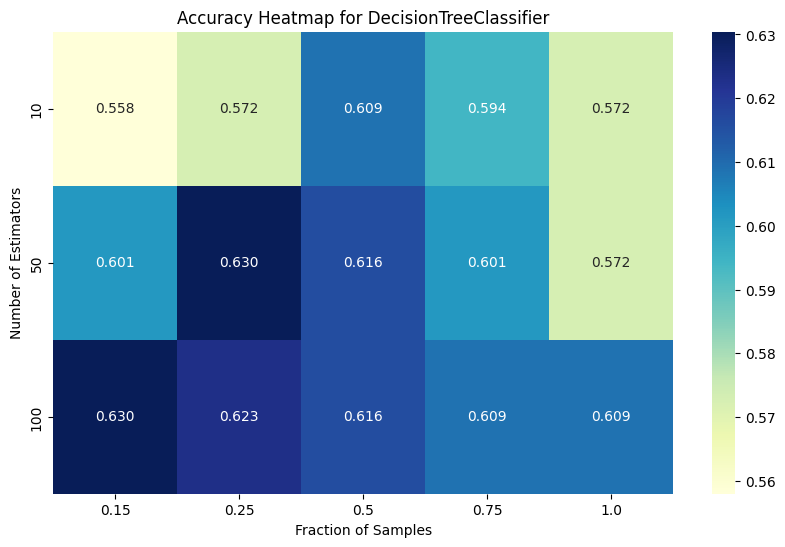

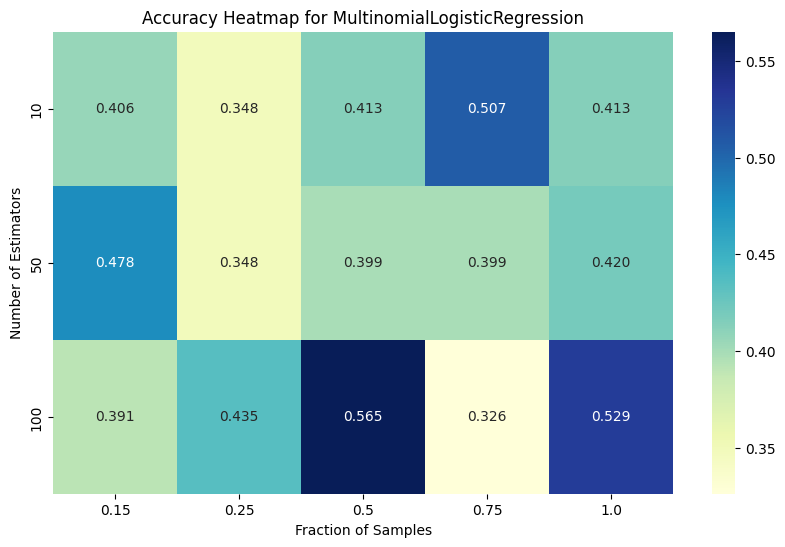

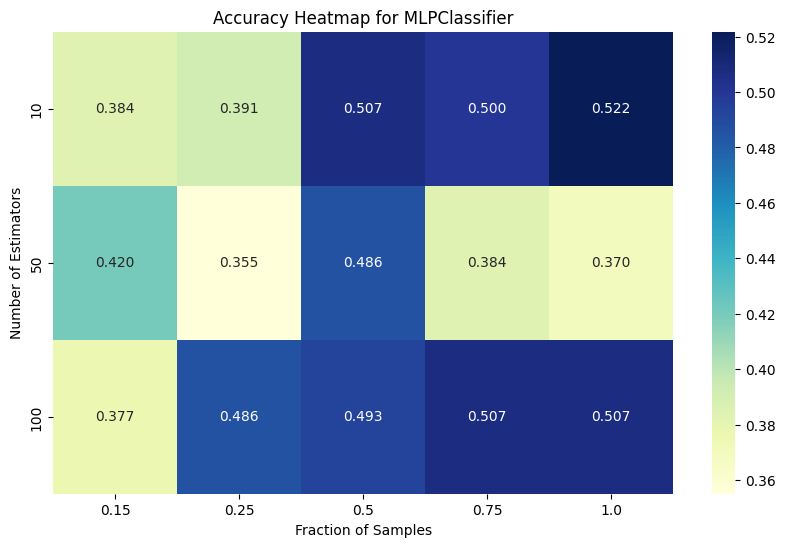

In [95]:
# Define the parameters for the heatmap
n_estimators_range = [10, 50, 100]
sample_fractions = [0.15,0.25, 0.5, 0.75, 1.0]
bootstrap_options = [True]
voting_options = ['soft']

heat_map(X_wine,y_wine,n_estimators_range,sample_fractions,bootstrap_options,voting_options,'classification')

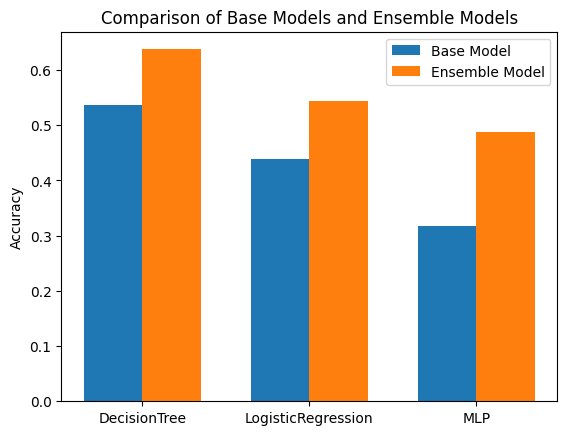

In [85]:
# Plot side-by-side histograms
labels = ['DecisionTree', 'LogisticRegression', 'MLP']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, base_model_accuracies_classification, width, label='Base Model')
rects2 = ax.bar(x + width/2, ensemble_model_accuracies_classfication, width, label='Ensemble Model')

ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Base Models and Ensemble Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

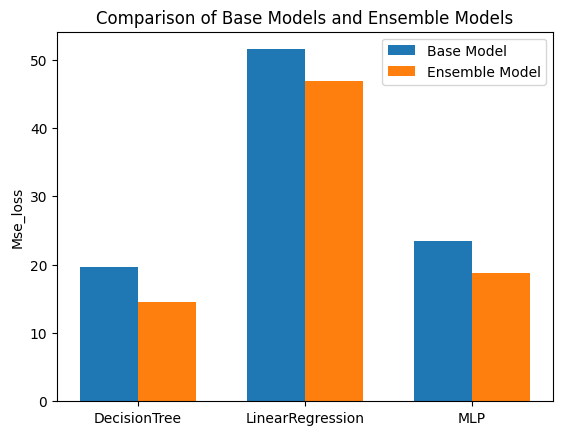

In [88]:
# Plot side-by-side histograms
labels = ['DecisionTree', 'LinearRegression', 'MLP']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, base_model_accuracies_regression, width, label='Base Model')
rects2 = ax.bar(x + width/2, ensemble_model_accuracies_regression, width, label='Ensemble Model')

ax.set_ylabel('Mse_loss')
ax.set_title('Comparison of Base Models and Ensemble Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [98]:
from sklearn.model_selection import KFold
import warnings
warnings.filterwarnings("ignore")

class StackEnsemble:
    def __init__(self, level0_estimators, level1_classifiers, level1_regressors, n_folds=4):
        self.level0_estimators = level0_estimators
        self.level1_classifiers = level1_classifiers
        self.level1_regressors = level1_regressors
        self.n_folds = n_folds
        self.level0_models = {}
        self.level1_classifier = None
        self.level1_regressor = None

    def train_level0_models(self, X_train, y_train):
        for estimator in self.level0_estimators:
            model = estimator()
            kf = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)

            for train_index, val_index in kf.split(X_train):
                X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
                y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

                model.fit(X_fold_train, y_fold_train)
                self.level0_models.setdefault(estimator.__name__, []).append(model)

    def train_level1_models(self, X_train, y_train, task):
        level0_predictions = self.get_level0_predictions(X_train)

        if task == 'classification':
            self.level1_classifier = MultinomialLogisticRegression()
            self.level1_classifier.fit(level0_predictions, y_train)
        elif task == 'regression':
            self.level1_regressor = LinearRegressor()
            self.level1_regressor.fit(level0_predictions, y_train)

    def get_level0_predictions(self, X):
        level0_predictions = []
        for model_name, models in self.level0_models.items():
            predictions = np.mean([model.predict(X) for model in models], axis=0)
            level0_predictions.append(predictions)
        return np.array(level0_predictions).T

    def predict_level1(self, X):
        if self.level1_classifier is not None:
            return self.level1_classifier.predict(self.get_level0_predictions(X))
        elif self.level1_regressor is not None:
            return self.level1_regressor.predict(self.get_level0_predictions(X))
        else:
            raise ValueError("No level-1 model trained")

    def evaluate(self, X, y, task):
        predictions = self.predict_level1(X)
        if task == 'classification':
            return accuracy_score(y, predictions)
        elif task == 'regression':
            return mean_squared_error(y, predictions)

    def train_blending_model(self, X_train, y_train, task):
        if task == 'classification':
            self.level1_classifier = MultinomialLogisticRegression()
        elif task == 'regression':
            self.level1_regressor = LinearRegressor()

        train_size = int(0.9 * X_train.shape[0])
        X_blend_train, y_blend_train = X_train[:train_size], y_train[:train_size]
        X_holdout, y_holdout = X_train[train_size:], y_train[train_size:]

        self.train_level0_models(X_blend_train, y_blend_train)
        level0_predictions = self.get_level0_predictions(X_holdout)

        if task == 'classification':
            self.level1_classifier.fit(level0_predictions, y_holdout)
        elif task == 'regression':
            self.level1_regressor.fit(level0_predictions, y_holdout)



In [99]:
# Define the lists of estimators
level0_estimators_regressor = [DecisionTreeRegressor, MLPRegressor]
level0_estimators_classifiers = [DecisionTreeClassifier, MLPClassifier]
level1_classifiers = [MultinomialLogisticRegression, DecisionTreeClassifier]
level1_regressors = [LinearRegressor, DecisionTreeRegressor]

best_accuracy = 0
best_regression_mse = float('inf')
best_params = {}

# Iterate over all combinations of parameters
X_train, X_val, X_test, y_train, y_val, y_test = get_data(X_wine, y_wine)

# For classification task on wine dataset
for level0_estimator_cls, level1_cls, level1_reg in product(level0_estimators_classifiers, level1_classifiers,
                                                            level1_regressors):
    for stacking_methodology in ['stacking', 'blending']:
        stack_ensemble = StackEnsemble([level0_estimator_cls], [level1_cls], [level1_reg])
        
        if stacking_methodology == 'blending':
            stack_ensemble.train_blending_model(X_train, y_train, task='classification')
        else:
            stack_ensemble.train_level0_models(X_train, y_train)
            
        stack_ensemble.train_level1_models(X_train, y_train, task='classification')
        accuracy = stack_ensemble.evaluate(X_test, y_test, task='classification')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params['classification'] = {
                'level0_estimator_cls': level0_estimator_cls,
                'level1_cls': level1_cls,
                'stacking_methodology': stacking_methodology
            }

X_train, X_val, X_test, y_train, y_val, y_test = get_data(X_housing, y_housing)

for level0_estimator_reg, level1_cls, level1_reg in product(level0_estimators_regressor, level1_classifiers,
                                                            level1_regressors):
    for stacking_methodology in ['stacking', 'blending']:
        # For regression task on housing dataset
        stack_ensemble = StackEnsemble([level0_estimator_reg], [level1_cls], [level1_reg])
        
        if stacking_methodology == 'blending':
            stack_ensemble.train_blending_model(X_train, y_train, task='regression')
        else:
            stack_ensemble.train_level0_models(X_train, y_train)
            
        stack_ensemble.train_level1_models(X_train, y_train, task='regression')
        mse = stack_ensemble.evaluate(X_test, y_test, task='regression')
        
        if mse < best_regression_mse:
            best_regression_mse = mse
            best_params['regression'] = {
                'level0_estimator_reg': level0_estimator_reg,
                'level1_reg': level1_reg,
                'stacking_methodology': stacking_methodology
            }

print(f"Best Classification Model - Accuracy: {best_accuracy}")
print(f"Best Parameters for Classification: {best_params['classification']}")
print("=" * 50)
print(f"Best Regression Model - Mean Squared Error: {best_regression_mse}")
print(f"Best Parameters for Regression: {best_params['regression']}")
print("=" * 50)

Best Classification Model - Accuracy: 0.5072463768115942
Best Parameters for Classification: {'level0_estimator_cls': <class '__main__.MLPClassifier'>, 'level1_cls': <class '__main__.MultinomialLogisticRegression'>, 'stacking_methodology': 'stacking'}
Best Regression Model - Mean Squared Error: 32.88738239298671
Best Parameters for Regression: {'level0_estimator_reg': <class 'sklearn.tree._classes.DecisionTreeRegressor'>, 'level1_reg': <class '__main__.LinearRegressor'>, 'stacking_methodology': 'stacking'}


In [109]:
# Define the lists of estimators
classification_estimators = [DecisionTreeClassifier, MultinomialLogisticRegression, MLPClassifier]
regression_estimators = [DecisionTreeRegressor, MLPRegressor]

X_train, X_val, X_test, y_train, y_val, y_test = get_data(X_wine, y_wine)

# For classification task on wine dataset
for level0_estimator_cls, level1_cls, level1_reg in product(classification_estimators, level1_classifiers, level1_regressors):
    for stacking_methodology in ["stacking", "blending"]:
        stack_ensemble = StackEnsemble([level0_estimator_cls], [level1_cls], [level1_reg])
        start_time = time.time()

        if stacking_methodology == "blending":
            stack_ensemble.train_blending_model(X_train, y_train, task="classification")
        else:
            stack_ensemble.train_level0_models(X_train, y_train)

        stack_ensemble.train_level1_models(X_train, y_train, task="classification")
        accuracy = stack_ensemble.evaluate(X_test, y_test, task="classification")
        training_time = time.time() - start_time

        classification_accuracies.append(accuracy)
        classification_training_times.append(training_time)

classification_accuracies = sorted(classification_accuracies, reverse=True)[:3]   
classification_training_times = sorted(classification_training_times, reverse=True)[:3]  


# Display results
print(f"Classification Accuracies: {classification_accuracies}")
print(f"Classification Training Times: {classification_training_times}")
print("=" * 50)


Classification Accuracies: [0.5797101449275363, 0.4782608695652174, 0.427536231884058]
Classification Training Times: [7.59778094291687, 7.432131052017212, 7.399519920349121]


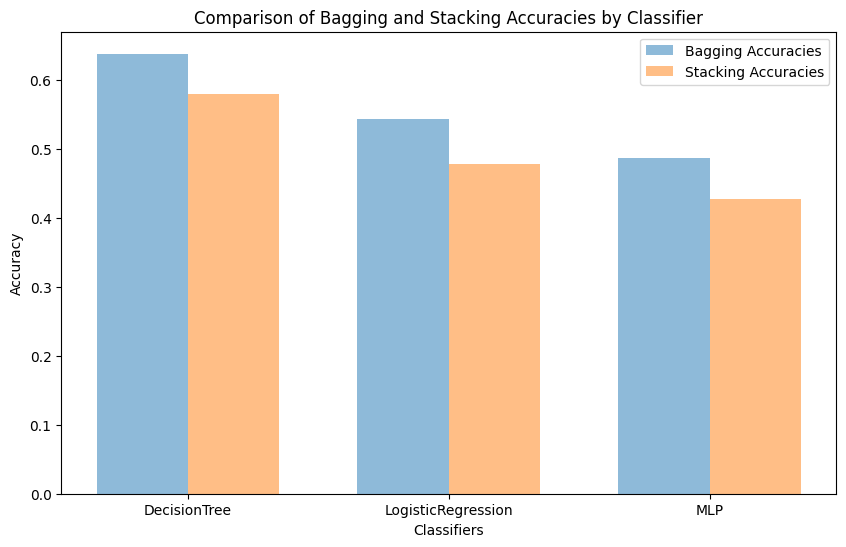

In [124]:
indices = np.arange(len(classification_accuracies))

# Mapping indices to classifiers
classifiers = {1: 'DecisionTree', 2: 'LogisticRegression', 3: 'MLP'}

# Plotting side-by-side histograms
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(indices - width/2, ensemble_model_accuracies_classfication, width, alpha=0.5, label='Bagging Accuracies')
plt.bar(indices + width/2, classification_accuracies, width, alpha=0.5, label='Stacking Accuracies')

plt.xlabel('Classifiers')
plt.ylabel('Accuracy')
plt.title('Comparison of Bagging and Stacking Accuracies by Classifier')
plt.xticks(indices, [classifiers[i+1] for i in range(len(classification_accuracies))])
plt.legend()

plt.show()

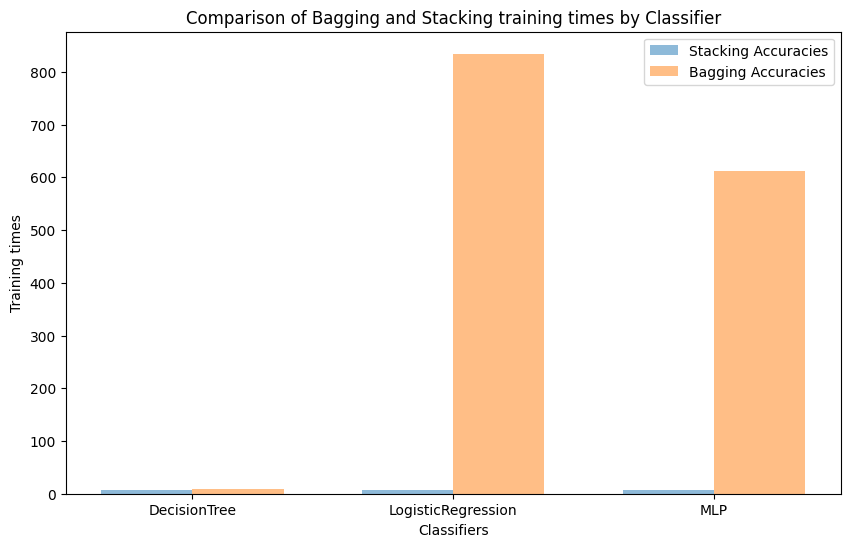

In [13]:
indices = np.arange(len(classification_training_times))

# Mapping indices to classifiers
classifiers = {1: 'DecisionTree', 2: 'LogisticRegression', 3: 'MLP'}

# Plotting side-by-side histograms
width = 0.35

plt.figure(figsize=(10, 6))

plt.bar(indices - width/2, classification_training_times, width, alpha=0.5, label='Stacking Accuracies')
plt.bar(indices + width/2, stacking_training_times, width, alpha=0.5, label='Bagging Accuracies')

plt.xlabel('Classifiers')
plt.ylabel('Training times')
plt.title('Comparison of Bagging and Stacking training times by Classifier')
plt.xticks(indices, [classifiers[i+1] for i in range(len(classification_training_times))])
plt.legend()

plt.show()